In [5]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import fits

In [8]:
flatspecs = sorted(glob.glob("../../../chris_kiran_jeffrey_lab2/star*.FIT"))
flatspecs = list(map(fits.open, flatspecs[:]))
master_flatspec = flatspecs[0][0].data

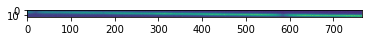

In [13]:
from matplotlib.colors import LogNorm
cropped = master_flatspec[25:40, :]
plt.imshow(cropped, norm=LogNorm(vmin=8e3, vmax=1e4));

In [110]:
y = np.mean(cropped, axis=0)

In [112]:
for i in range(500,len(y)):
    if y[i] == np.min(y[500:650]):
        H_abs_loc = i
shift = 4861 - H_abs_loc

4277

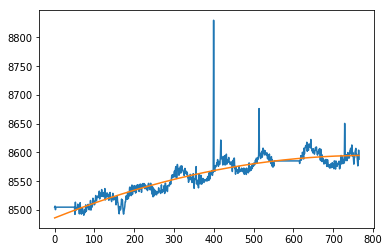

In [98]:
x = np.linspace(0,len(cropped[0]), len(cropped[0]))
N = 2
fitfunc = np.poly1d(np.polyfit(x,y,N))
for i in range(len(y)):
    if 2<i<50 :
        y[i]=(y[1]+y[50])/2
    if 550<i<615:
        y[i]=(y[549]+y[620])/2
plt.plot(x,y)
plt.plot(x,fitfunc(x))

In [23]:
N = 2
fitfunc = np.poly1d(np.polyfit(x,y,N)) #creates a function that takes in a point and fits it to all data

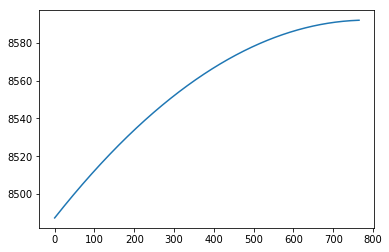

In [92]:
plt.plot(x,fitfunc(x))

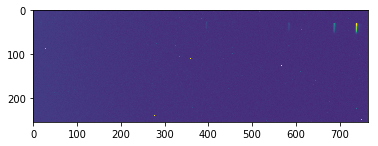

In [93]:
nebulae = sorted(glob.glob("../../../chris_kiran_jeffrey_lab2/nebula*.FIT"))
nebulae = list(map(fits.open, nebulae[:]))
nebulae = nebulae[0][0].data
plt.imshow(nebulae, norm=LogNorm(vmin=8e3, vmax=1e4));

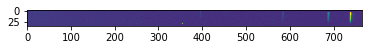

In [94]:
nebulae = nebulae[25:60, :]
plt.imshow(nebulae, norm=LogNorm(vmin=8e3, vmax=1e4));

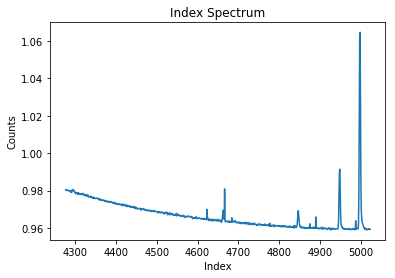

In [113]:
neb_norm = nebulae/fitfunc(x)
mean = np.mean(neb_norm, axis=0)
ang_per_pix = 0.9747780194475906
#use shift to display angstroms of location
plt.plot(np.linspace(shift,shift + neb_norm.shape[1]*ang_per_pix, num=len(mean)),mean) 
#.97 is the angstroms per pixel that was previously calculated in lab0
plt.title("Index Spectrum")
plt.xlabel("Index")
plt.ylabel("Counts");